# Entraînement des modèles pour la détection de pneumonie

Ce notebook présente l'entraînement de différents modèles de deep learning pour la détection de pneumonie à partir d'images radiographiques.

In [1]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pour éviter les avertissements
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Chargement et préparation des données

Nous allons d'abord charger les données et les préparer pour l'entraînement.

In [2]:
# Définir le chemin vers les données
data_dir = r'C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\data'

# Fonction pour charger les images
def load_images_from_dir(directory, img_size=(224, 224), max_images=None):
    """
    Charge les images d'un répertoire avec leurs étiquettes.
    
    Args:
        directory (str): Chemin vers le répertoire contenant les images
        img_size (tuple): Taille des images après redimensionnement
        max_images (int): Nombre maximum d'images à charger par classe
        
    Returns:
        tuple: Images, étiquettes et noms de fichiers
    """
    images = []
    labels = []
    filenames = []
    
    # Vérifier si le répertoire existe
    if not os.path.exists(directory):
        print(f"Le répertoire {directory} n'existe pas.")
        return np.array([]), np.array([], dtype=int), []
    
    # Parcourir les sous-répertoires (classes)
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        # Déterminer l'étiquette (0 pour normal, 1 pour pneumonie)
        label = 0 if class_name.lower() == 'normal' else 1
        
        # Parcourir les images dans le sous-répertoire
        img_count = 0
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            if max_images is not None and img_count >= max_images:
                break
                
            img_path = os.path.join(class_dir, img_name)
            
            # Charger et prétraiter l'image
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Impossible de charger l'image {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB
                img = cv2.resize(img, img_size)  # Redimensionner
                
                images.append(img)
                labels.append(label)
                filenames.append(img_path)
                img_count += 1
            except Exception as e:
                print(f"Erreur lors du chargement de l'image {img_path}: {e}")
    
    # Convertir les labels en int pour éviter l'erreur avec bincount
    return np.array(images), np.array(labels, dtype=int), filenames

# Vérifier la structure du dossier de données
print(f"Vérification du dossier de données: {data_dir}")
if os.path.exists(data_dir):
    print("Le dossier de données existe.")
    print(f"Contenu du dossier: {os.listdir(data_dir)}")
else:
    print("Le dossier de données n'existe pas!")

# Vérifier si le dossier a la structure attendue (train, val, test)
expected_structure = ['train', 'val', 'test']
has_expected_structure = all(os.path.isdir(os.path.join(data_dir, d)) for d in expected_structure)

if has_expected_structure:
    # Charger les images depuis les sous-dossiers train, val et test
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')
    
    print("\nChargement des images...")
    X_train, y_train, train_filenames = load_images_from_dir(train_dir)
    X_val, y_val, val_filenames = load_images_from_dir(val_dir)
    X_test, y_test, test_filenames = load_images_from_dir(test_dir)
    
    # Afficher le nombre d'images chargées
    print(f"\nNombre d'images chargées:")
    print(f"  - Train: {len(X_train)} images")
    print(f"  - Validation: {len(X_val)} images")
    print(f"  - Test: {len(X_test)} images")
    
    # Afficher la distribution des classes
    print("\nDistribution des classes:")
    if len(y_train) > 0:
        print(f"  - Train: {np.bincount(y_train)}")
    if len(y_val) > 0:
        print(f"  - Validation: {np.bincount(y_val)}")
    if len(y_test) > 0:
        print(f"  - Test: {np.bincount(y_test)}")
    
    # Normaliser les images
    print("\nNormalisation des images...")
    X_train = X_train / 255.0 if len(X_train) > 0 else X_train
    X_val = X_val / 255.0 if len(X_val) > 0 else X_val
    X_test = X_test / 255.0 if len(X_test) > 0 else X_test
else:
    # Structure alternative: charger directement depuis le dossier principal
    print("\nStructure de dossier standard non trouvée. Recherche d'une structure alternative...")
    
    # Vérifier s'il y a des dossiers de classes directement dans le dossier principal
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d not in expected_structure]
    
    if class_dirs:
        print(f"Dossiers de classes trouvés directement: {class_dirs}")
        print("Chargement des images et division manuelle en ensembles d'entraînement, de validation et de test...")
        
        # Charger toutes les images
        images, labels, filenames = load_images_from_dir(data_dir)
        
        if len(images) > 0:
            # Afficher le nombre d'images chargées
            print(f"Nombre d'images chargées: {len(images)}")
            print(f"Distribution des classes: {np.bincount(labels)}")
            
            # Diviser les données en ensembles d'entraînement, de validation et de test
            X_train, X_temp, y_train, y_temp = train_test_split(
                images, labels, test_size=0.3, random_state=42, stratify=labels
            )
            
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
            )
            
            # Afficher la distribution des ensembles
            print("\nDistribution après division:")
            print(f"  - Train: {len(X_train)} images, {np.bincount(y_train)}")
            print(f"  - Validation: {len(X_val)} images, {np.bincount(y_val)}")
            print(f"  - Test: {len(X_test)} images, {np.bincount(y_test)}")
            
            # Normaliser les images
            print("\nNormalisation des images...")
            X_train = X_train / 255.0
            X_val = X_val / 255.0
            X_test = X_test / 255.0
        else:
            print("Aucune image n'a été chargée.")
    else:
        print("Aucune structure de données valide n'a été trouvée.")
        print("Veuillez vérifier le chemin et la structure du dossier de données.")
        X_train, y_train = np.array([]), np.array([], dtype=int)
        X_val, y_val = np.array([]), np.array([], dtype=int)
        X_test, y_test = np.array([]), np.array([], dtype=int)

print("\nPréparation des données terminée.")

Vérification du dossier de données: C:\Users\Krikri\Documents\EPITECH\MSc\Msc1\T-DEV-810-PAR-29\epitech_docs\detection_pneumonie_ia\data
Le dossier de données existe.
Contenu du dossier: ['test', 'train', 'val']

Chargement des images...

Nombre d'images chargées:
  - Train: 5216 images
  - Validation: 16 images
  - Test: 624 images

Distribution des classes:
  - Train: [1341 3875]
  - Validation: [8 8]
  - Test: [234 390]

Normalisation des images...

Préparation des données terminée.


## 2. Augmentation des données

L'augmentation des données est une technique qui permet d'augmenter artificiellement la taille du jeu de données d'entraînement en appliquant diverses transformations aux images existantes.

Exemples d'augmentation sur une image normale:


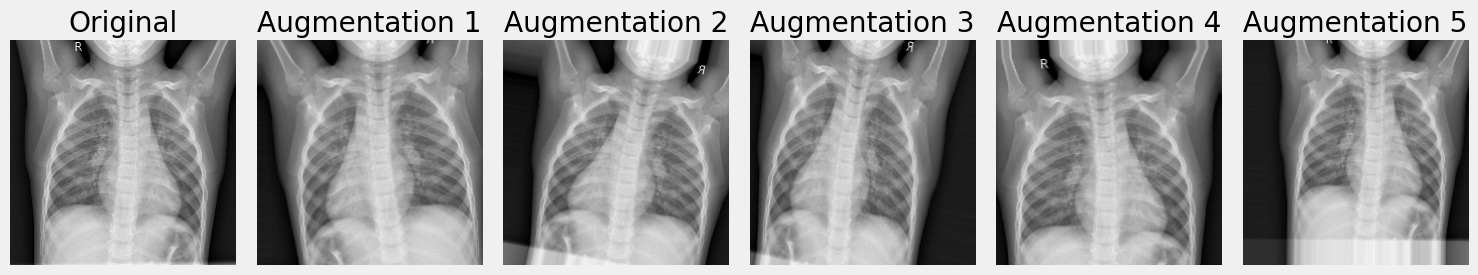


Exemples d'augmentation sur une image de pneumonie:


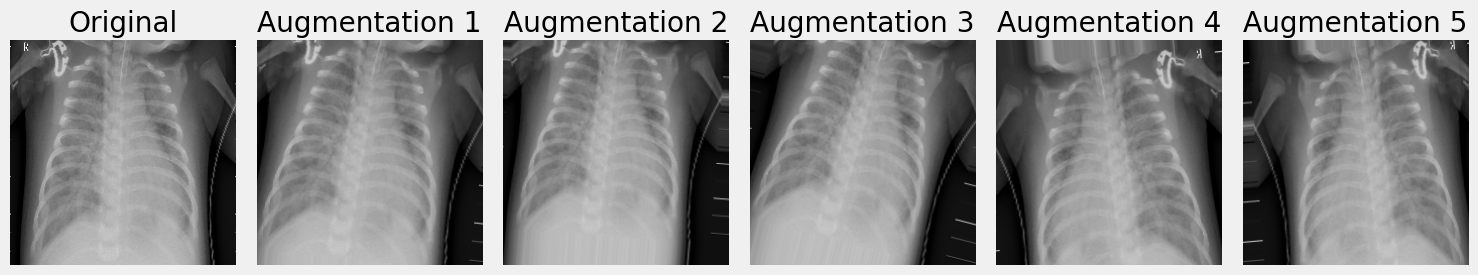

In [3]:
# Configurer le générateur d'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotation aléatoire jusqu'à 15 degrés
    width_shift_range=0.1,    # Décalage horizontal jusqu'à 10%
    height_shift_range=0.1,   # Décalage vertical jusqu'à 10%
    shear_range=0.1,          # Cisaillement jusqu'à 10%
    zoom_range=0.1,           # Zoom aléatoire jusqu'à 10%
    horizontal_flip=True,     # Retournement horizontal
    fill_mode='nearest'       # Stratégie de remplissage des pixels manquants
)

# Visualiser quelques exemples d'augmentation
def visualize_augmentation(image, num_augmentations=5):
    """
    Visualise des exemples d'augmentation de données sur une image.
    
    Args:
        image (numpy.ndarray): Image à augmenter
        num_augmentations (int): Nombre d'exemples à générer
    """
    # Ajouter une dimension de batch
    image_batch = np.expand_dims(image, axis=0)
    
    # Créer un générateur d'augmentation
    aug_iter = datagen.flow(image_batch, batch_size=1)
    
    # Visualiser l'image originale et les augmentations
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 5))
    
    # Image originale
    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Images augmentées
    for i in range(num_augmentations):
        augmented_image = next(aug_iter)[0].astype(np.float32)
        axes[i+1].imshow(augmented_image)
        axes[i+1].set_title(f'Augmentation {i+1}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualiser des exemples d'augmentation sur une image normale et une image de pneumonie
if len(X_train) > 0:
    # Trouver une image normale et une image de pneumonie
    normal_idx = np.where(y_train == 0)[0][0]
    pneumonia_idx = np.where(y_train == 1)[0][0]
    
    print("Exemples d'augmentation sur une image normale:")
    visualize_augmentation(X_train[normal_idx])
    
    print("\nExemples d'augmentation sur une image de pneumonie:")
    visualize_augmentation(X_train[pneumonia_idx])

## 3. Création des modèles

Nous allons créer différents modèles pour la détection de pneumonie :
1. Un CNN simple
2. Un modèle utilisant le transfer learning avec VGG16
3. Un modèle utilisant le transfer learning avec ResNet50

In [4]:
def create_cnn_model(input_shape=(224, 224, 3)):
    """
    Crée un modèle CNN simple.
    
    Args:
        input_shape (tuple): Forme des images d'entrée
        
    Returns:
        tensorflow.keras.models.Model: Modèle CNN
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sortie binaire: normal vs pneumonie
    ])
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_vgg16_model(input_shape=(224, 224, 3)):
    """
    Crée un modèle utilisant le transfer learning avec VGG16.
    
    Args:
        input_shape (tuple): Forme des images d'entrée
        
    Returns:
        tensorflow.keras.models.Model: Modèle de transfer learning
    """
    # Charger le modèle VGG16 pré-entraîné sans les couches fully-connected
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Geler les couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Ajouter des couches personnalisées
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Taux d'apprentissage plus faible pour le transfer learning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_resnet50_model(input_shape=(224, 224, 3)):
    """
    Crée un modèle utilisant le transfer learning avec ResNet50.
    
    Args:
        input_shape (tuple): Forme des images d'entrée
        
    Returns:
        tensorflow.keras.models.Model: Modèle de transfer learning
    """
    # Charger le modèle ResNet50 pré-entraîné sans les couches fully-connected
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Geler les couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Ajouter des couches personnalisées
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Taux d'apprentissage plus faible pour le transfer learning
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model